In [1]:
import scSpace
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import pandas as pd
import random
import torch
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/scspace_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    
setup_seed(123)

In [3]:
sc_data_dir = 'data/melanoma_sc_data.csv'
sc_meta_dir = 'data/melanoma_sc_meta.csv'
st_data_dir = 'data/melanoma_st_data.csv'
st_meta_dir = 'data/melanoma_st_meta.csv'

sc_obj, st_obj = scSpace.load_data(
    sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, 
    st_data_path=st_data_dir, st_meta_path=st_meta_dir,
    spatial_key=['xcoord','ycoord'])

Loading data...
Data have been loaded.


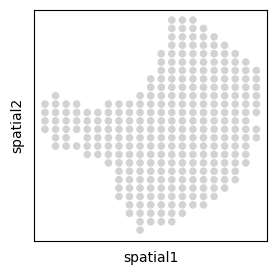

In [4]:
# ST reference 
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(st_obj, basis="spatial", s=120)

In [5]:
sc_obj_hvg, st_obj_hvg = scSpace.preporcess(
    sc_adata=sc_obj, st_adata=st_obj, st_type='spot', n_features=2000, 
    normalize=True, select_hvg='union')

Data have been pre-processed.


In [6]:
sc_obj_hvg, st_obj_hvg = scSpace.construct_pseudo_space(
    sc_adata=sc_obj_hvg,
    st_adata=st_obj_hvg,
    batch_size=16,
    hidden_size=128,
    activation='sigmoid',
    lr=0.001,
    epoch_num=1000,
    log_epoch=1000
)

Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|██████████| 1000/1000 [00:22<00:00, 43.97it/s]

Epoch [1000/1000]: Batch loss=7.646035671234131
Encoder for source domain training finished.


In [7]:
# Spatial-informed clustering of T subpopulations
tcell_adata = sc_obj_hvg[sc_obj_hvg.obs['Cell_type'].isin(['T cell'])]
tcell_adata = scSpace.spatial_cluster(
    sc_adata=tcell_adata,
    Ks=20,
    Kg=10,
    res=0.5,
    target_num=5
)

Calculating spatial weights using the neighbours of spots...
Start at res =  0.5 step =  0.1
Res =  0.5 number of clusters =  6
Res =  0.4 number of clusters =  4
Step changed to 0.05
Res =  0.45 number of clusters =  5
Recommended res =  0.45


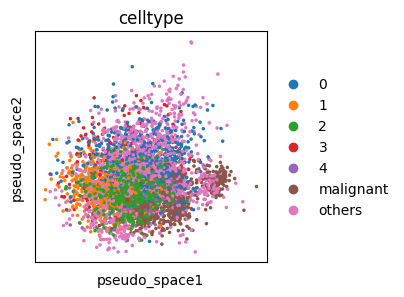

In [9]:
# The distance between T subpopulations and melanoma in pseudo space
sc_obj_hvg.obs['celltype'] = sc_obj_hvg.obs['Cell_type'].astype('str')
sc_obj_hvg.obs.celltype[sc_obj_hvg.obs['celltype'].isin(['B cell', 'CAF', 'Endo', 'Macro', 'NK'])] = 'others'
sc_obj_hvg.obs.celltype[sc_obj_hvg.obs['celltype'].isin(['T cell'])] = tcell_adata.obs['scSpace'].astype('str')
sc_obj_hvg.obs['celltype'] = sc_obj_hvg.obs['celltype'].astype('category')

sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color="celltype")

In [10]:
# calculate distacne
dist_res = scSpace.utils.cal_dist_group(
    sc_adata=sc_obj_hvg[sc_obj_hvg.obs['Cell_type'].isin(['T cell', 'malignant'])], 
    group_key='celltype', 
    select_group='malignant')

Calculating all cell pairs between malignant and 0 ...


100%|██████████| 702/702 [00:04<00:00, 153.90it/s]


Calculating all cell pairs between malignant and 1 ...


100%|██████████| 681/681 [00:04<00:00, 153.18it/s]


Calculating all cell pairs between malignant and 2 ...


100%|██████████| 312/312 [00:02<00:00, 153.72it/s]


Calculating all cell pairs between malignant and 3 ...


100%|██████████| 250/250 [00:01<00:00, 153.71it/s]


Calculating all cell pairs between malignant and 4 ...


100%|██████████| 119/119 [00:00<00:00, 153.78it/s]


Calculating all cell pairs between malignant and malignant ...


100%|██████████| 1257/1257 [00:04<00:00, 305.95it/s]


In [11]:
dist_res = [dist_res[0], dist_res[1], dist_res[2], dist_res[3], dist_res[4]]

<AxesSubplot: >

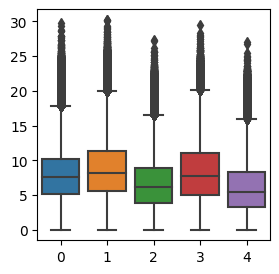

In [12]:
sns.boxplot(data=dist_res)

categories: 0, 1, 2, etc.
var_group_labels: T1, T2, T3, etc.


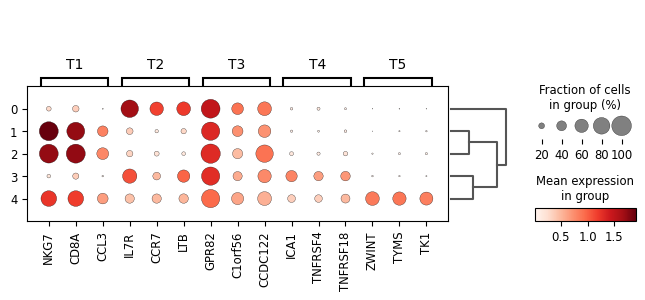

In [13]:
marker_genes_dict = {
    'T1': ['NKG7', 'CD8A', 'CCL3'],
    'T2': ['IL7R', 'CCR7', 'LTB'],
    'T3': ['GPR82', 'C1orf56', 'CCDC122'],
    'T4': ['ICA1', 'TNFRSF4', 'TNFRSF18'],
    'T5': ['ZWINT', 'TYMS', 'TK1'],
}

sc.pl.dotplot(tcell_adata, marker_genes_dict, 'scSpace', dendrogram=True)

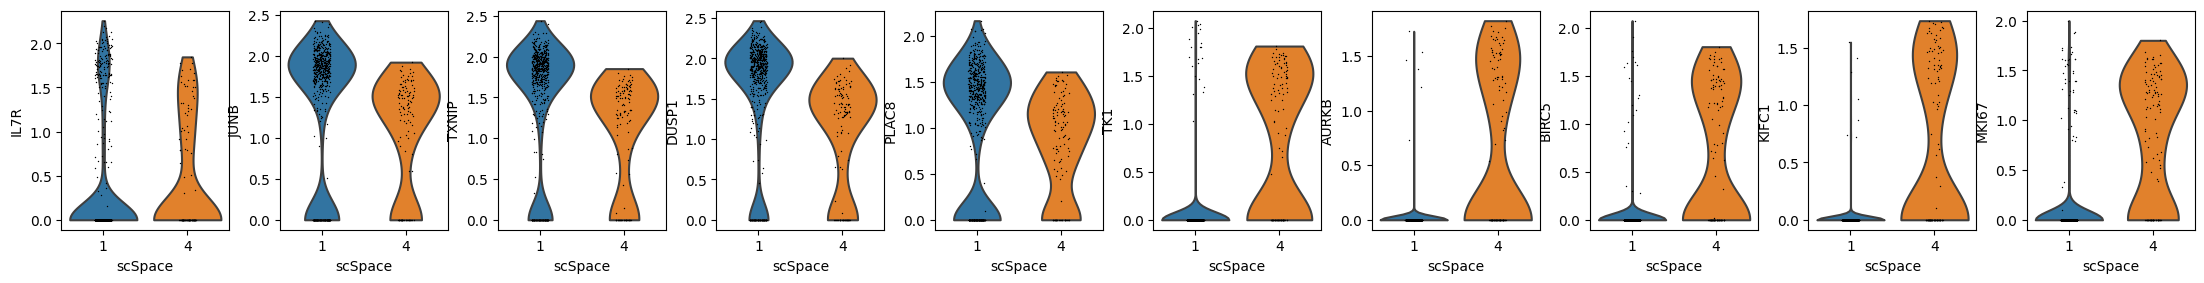

In [16]:
# select T subpopulations nearest/farthest to malignant
genes = ['IL7R', 'JUNB', 'TXNIP', 'DUSP1', 'PLAC8', 'TK1', 'AURKB', 'BIRC5', 'KIFC1', 'MKI67']
sc.pl.violin(tcell_adata[tcell_adata.obs['scSpace'].isin(['1', '4'])], genes, groupby='scSpace')